# Inference MicNet model


In [25]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re
import sys

import skimage
import skimage.io
import tifffile

import time
import torch
import torch.hub
import torch.nn


from MicNet_model import *

## 1) Load data

(25233, 27452, 3)


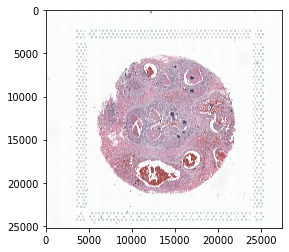

In [26]:
### Read counts
count_stat = pd.read_csv("./run/1_count_stat_breast_cancer_FFPE.csv", index_col=0)
count = pd.read_csv("./run/1_pd_count_norm_breast_cancer_FFPE.csv", index_col=0)
image_file = "./dataset/Visium_FFPE_Human_Breast_Cancer_image.tif"
image = tifffile.imread(os.path.join(image_file))
print(image.shape)
image_norm = image.copy()
plt.imshow(image_norm)
plt.show()

In [27]:
# Read position meta file
transformation_file =  "./dataset/Spot_metadata.csv"
pd_meta = pd.read_table(transformation_file, index_col=0, sep=",")
pd_meta

,Row,Col,X,Y,Spot_radius
0,,,,,
GTAGACAACCGATGAA-1,7,55,5406,13126,94
ACAGATTAGGTTAGTG-1,7,57,5407,13417,94
TGGTATCGGTCTGTAT-1,7,59,5407,13707,94
ATTATCTCGACAGATC-1,7,61,5407,13997,94
TGAGATCAAATACTCA-1,7,63,5407,14287,94
...,...,...,...,...,...
GCCCTGAGGATGGGCT-1,68,74,20805,15869,94
CGGGCGATGGATCACG-1,69,75,21057,16013,94
TGCGGACTTGACTCCG-1,68,76,20805,16159,94


In [28]:
# Split training and testing
np.random.seed(82321)
indexes_all = pd_meta.index.values.copy()
training_indexes = np.random.choice(indexes_all, int(len(indexes_all) * 0.8), replace=False)
testing_indexes = [_ for _ in indexes_all if _ not in training_indexes]
print("#Training: {}, #Testing: {}".format(len(training_indexes), len(testing_indexes)))
training_indexes.sort()
testing_indexes.sort()

#Training: 2014, #Testing: 504


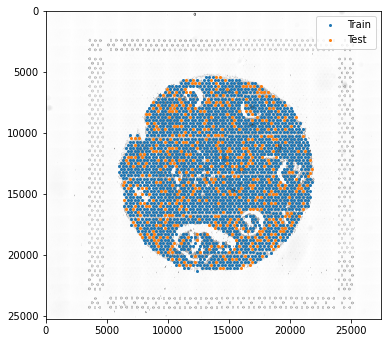

In [29]:
# Plot training & testing distribution
plt.figure(figsize=(6, 6))
plt.imshow(image_norm[..., 0], cmap="gray")
coords_x = pd_meta.loc[training_indexes, "Y"].values
coords_y = pd_meta.loc[training_indexes, "X"].values
plt.scatter(coords_x, coords_y, s=4, label="Train")
coords_x = pd_meta.loc[testing_indexes, "Y"].values
coords_y = pd_meta.loc[testing_indexes, "X"].values
plt.scatter(coords_x, coords_y, s=4, label="Test")
plt.gca().set_aspect('equal')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.legend()
plt.show()

## 2) Check data loader

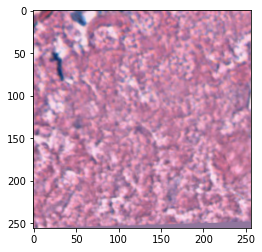

tensor([449])


In [31]:
# Generator
np.random.seed()
train_set = Dataset(training_indexes, image_norm, count, pd_meta, augmentation=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)
for x, y in train_loader:
    plt.imshow(normalize(np.transpose(x['image'][0].numpy(), (1, 2, 0)), inverse=True))
    plt.show()
    print(y)
    break

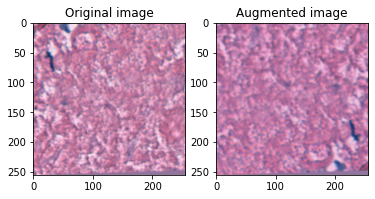

In [32]:
image = normalize(np.transpose(x['image'][0].numpy(), (1, 2, 0)), inverse=True)
plt.subplot(121)
plt.imshow(image)
plt.title("Original image")
plt.subplot(122)
plt.imshow(normalize(augmentor(normalize(image)), inverse=True))
plt.title("Augmented image")
plt.show()

## 3) Create network

In [33]:
from torch.nn.modules import MSELoss
from utils_eval import NCESoftmaxLoss, NCECriterion

device = torch.device("cuda:0")
image_shape = 256
n_genes = count_stat.shape[1]
n_data = len(training_indexes)
n_out_features = 100
imagenet = 'resnet101'

# NCE parameters
# Increasing nce_m improves stability
nce_k = 100
nce_t = 0.07
nce_m = 0.9
softmax = False

# Training parameters
# Decreasing lr and adding gradient_clip improves stability
lr = 0.01   # ori 0.01
momentum = 0.9
weight_decay = 0.0001
gradient_clip = 5

# Generator
train_set = Dataset(training_indexes, image_norm, count, pd_meta, augmentation=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20, shuffle=True, num_workers=1)
test_set = Dataset(testing_indexes, image_norm, count, pd_meta, augmentation=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False, num_workers=1)

# Set model
model = MicNet(image_shape=image_shape, n_genes=n_genes, n_out_features=n_out_features, 
               imagenet=imagenet, genenet=[500, 100]).to(device)
contrast = NCEAverage(n_out_features, n_data, nce_k, nce_t, nce_m, softmax, device=device).to(device)
criterion_image = NCESoftmaxLoss().to(device) if softmax else NCECriterion(n_data).to(device)
criterion_gene = NCESoftmaxLoss().to(device) if softmax else NCECriterion(n_data).to(device)
criterion_rec = MSELoss().to(device)

# Set optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=lr,
                            momentum=momentum,
                            weight_decay=weight_decay)

Using cache found in /home2/s223242/.cache/torch/hub/pytorch_vision_v0.4.0


In [34]:
model_dir = "./models/2_MicNet_breast_cancer_FFPE"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [35]:
model

MicNet(
  (imagenet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [37]:
"""TO LOAD:"""

model_file = os.path.join(model_dir, "epoch_best_breast.pt")
if model_file is not None:
    print("=> loading checkpoint '{}'".format(model_file))
    checkpoint = torch.load(model_file, map_location=device)
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    contrast.load_state_dict(checkpoint['contrast'])
    del checkpoint

=> loading checkpoint './models/2_MicNet_breast_cancer_FFPE/epoch_best_breast.pt'


## 4) Validate and save result

In [38]:
test_set = Dataset(indexes_all, image_norm, count, pd_meta, augmentation=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=False, num_workers=1)

In [39]:
model.eval()

with torch.no_grad():
    for idx, (data, index) in enumerate(test_loader):
        batch_size = data['image'].size(0)
        index = index.to(device)
        for _ in data.keys():
            data[_] = data[_].float().to(device)

        # ===================forward=====================
        feat_image, feat_gene = model(data)
        
        # Append
        if idx == 0:
            feat_images = feat_image.cpu().numpy()
            feat_genes = feat_gene.cpu().numpy()
        else:
            feat_images = np.concatenate([feat_images, feat_image.cpu().numpy()])
            feat_genes = np.concatenate([feat_genes, feat_gene.cpu().numpy()])

In [40]:
feat_images.shape

(2518, 100)

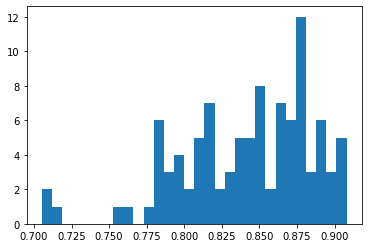

In [41]:
# Normalize & calculate correlation
from scipy.stats import spearmanr

feat_images = feat_images / np.sum(feat_images ** 2, axis=1, keepdims=True) ** 0.5
feat_genes = feat_genes / np.sum(feat_genes ** 2, axis=1, keepdims=True) ** 0.5
corr = []
for i in range(feat_images.shape[1]):
    corr.append(spearmanr(feat_images[:, i], feat_genes[:, i]).correlation)
plt.hist(corr, bins=30)
plt.show()

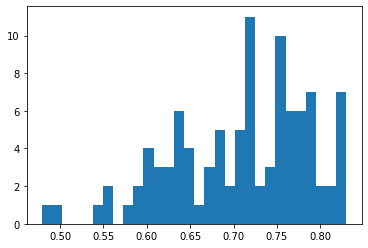

In [42]:
# Normalize & calculate correlation in testing set
from scipy.stats import spearmanr

_feat_images = np.array([feat_images[_, :] for _, index in enumerate(indexes_all) if index in testing_indexes])
_feat_genes = np.array([feat_genes[_, :] for _, index in enumerate(indexes_all) if index in testing_indexes])
corr = []
for i in range(_feat_images.shape[1]):
    corr.append(spearmanr(_feat_images[:, i], _feat_genes[:, i]).correlation)
plt.hist(corr, bins=30)
plt.show()

In [43]:
# Save result
torch.save([feat_images, feat_genes], "./output/3_IGC_breast_cancer_FFPE_all_indexes_features.pt")